<a href="https://colab.research.google.com/github/odie2630463/pyro_tutorial/blob/master/Unsupervised_object_detection_with_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised object detection with pyro

simplify the model and borrow idea from list paper

- [Spatially Invariant Unsupervised Object Detection with Convolutional Neural
Networks
](http://e2crawfo.github.io/pdfs/spair_aaai_2019.pdf)
-[Attend, Infer, Repeat: Fast Scene Understanding with Generative Models](https://arxiv.org/abs/1603.08575)

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 430kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import widgets

import torch
import torch.nn as nn
from torch.distributions import constraints
from torch.nn.functional import grid_sample, affine_grid
from torchvision.utils import make_grid

import pyro
import pyro.distributions as dist
from pyro.poutine import trace,replay
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI,Trace_ELBO

In [0]:
img_size = 64
obj_size = 8
ratio = img_size / obj_size
logit_scale = 10

batch_size = 2
H = 4
W = 4
C = 2

## Differential image render


In [0]:
def obj_to_image_param(obj_param):
  H_ = torch.arange(-ratio,ratio,(2*ratio)/H)
  W_ = torch.arange(-ratio,ratio,(2*ratio)/W)
  base = [torch.stack((i,j)) for i in H_ for j in W_]
  base = torch.stack(base).view(1,H,W,1,2).repeat(1,1,1,C,1)
  return (ratio/4)*(obj_param+1)+base

In [0]:
def render(obj_param,logit):
  img_param = obj_to_image_param(obj_param)
  img_param = img_param.view(-1,2)
  logit = (logit_scale*logit.view(-1,1,1,1)).sigmoid()
  bs = img_param.size(0)
  obj = torch.ones((bs,1,obj_size,obj_size))*logit
  theta = torch.zeros(bs,2,3)
  theta[:,0,0] = ratio
  theta[:,1,1] = ratio
  theta[:,:,-1] = img_param
  grid = affine_grid(theta, torch.Size((bs,1,img_size,img_size)))
  out = grid_sample(obj, grid)
  out = out.view(batch_size,-1,1,img_size,img_size)
  return out , out.sum(1)

In [0]:
out , img_ = render(torch.zeros(2,4,4,2,2),torch.ones(2,4,4,2,1))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


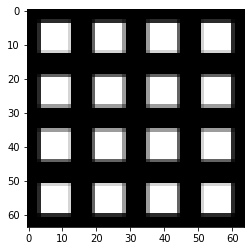

In [0]:
plt.imshow(img_[1].view(img_size,img_size).numpy(),cmap='gray',vmin=0)

## Define Yolo like model

- assume image have $4*4*2=32$ objects
- each object has *location param* and *logit*


In [0]:
#(2,4,4,2,2)
def model(obs):
  B = pyro.plate('B',size=batch_size,dim=-5)
  H = pyro.plate('H',size=4,dim=-4)
  W = pyro.plate('W',size=4,dim=-3)
  C = pyro.plate('C',size=2,dim=-2)

  with B,H,W,C:
    pos = pyro.sample('obj_param',dist.Normal(torch.zeros(2),torch.ones(2)))
    logit = pyro.sample('obj_logit',dist.Normal(torch.tensor(-1.),torch.ones(1)))
  
  out , imgs_ = render(pos,logit)
  imgs = pyro.sample('images',dist.Normal(imgs_ , 0.01*torch.ones_like(imgs_)).to_event(2) , obs=obs)
  return out , imgs

### sample 2 images for training

torch.Size([2, 1, 64, 64])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


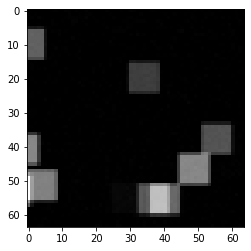

In [0]:
out , imgs = model(None)
print(imgs.shape)
plt.imshow(imgs[0].view(img_size,img_size).numpy(),cmap='gray',vmin=0)

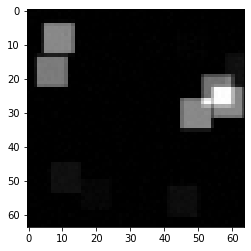

In [0]:
plt.imshow(imgs[1].view(img_size,img_size).numpy(),cmap='gray',vmin=0)

### show each object 

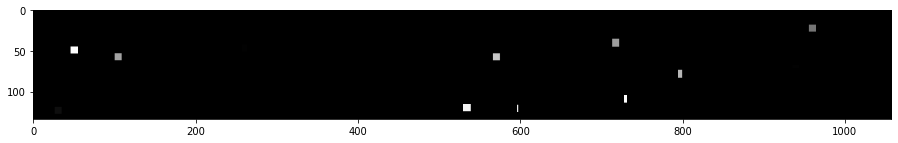

In [0]:
plt.figure(figsize = (20,2))
plt.imshow(make_grid(out[0],nrow=16).numpy().transpose((1,2,0)))

## Define guide

In [0]:
#guide = AutoDelta(pyro.poutine.block(model, expose=["obj_param","obj_logit"]))

In [0]:
encoder = nn.Sequential(nn.Conv2d(1,16,3,2,1),
                        nn.ReLU(),
                        nn.Conv2d(16,32,3,2,1),
                        nn.ReLU(),
                        nn.Conv2d(32,32,3,2,1),
                        nn.ReLU(),
                        nn.Conv2d(32,16,3,2,1),
                        nn.ReLU(),
                        nn.Conv2d(16,6,1,1))

In [0]:
def guide(imgs):
  pyro.module("encoder", encoder)
  feats = encoder(imgs).permute(0,2,3,1).view(batch_size,H,W,C,3).contiguous()
  s1 = pyro.sample('obj_logit',dist.Delta(feats[:,:,:,:,:1]))
  s2 = pyro.sample('obj_param',dist.Delta(feats[:,:,:,:,1:]))
  return s1,s2

## Do inference

In [0]:
pyro.clear_param_store()
elbo = Trace_ELBO()
optim = pyro.optim.Adam({'lr': 1e-3})
svi = SVI(model, guide, optim, loss=elbo)

In [0]:
for _ in range(1000):
  loss = svi.step(imgs)
print(loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


273801.7240447998


## Check reconstruction

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


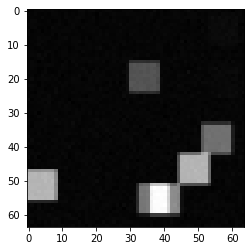

In [0]:
guide_trace = pyro.poutine.trace(guide).get_trace(imgs)
out_,sample = pyro.poutine.replay(model, guide_trace)(None)
plt.imshow(sample[0].view(img_size,img_size).detach().numpy(),cmap='gray')

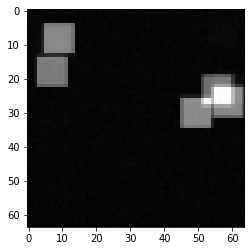

In [0]:
plt.imshow(sample[1].view(img_size,img_size).detach().numpy(),cmap='gray')

## Draw bounding box

In [0]:
def get_bbox(obj_param,obj_logit,t=0.5):
  obj_logit = (obj_logit*logit_scale).sigmoid().view(-1)
  img_param = obj_to_image_param(obj_param).view(-1,2)
  filter_img_param = img_param[obj_logit>t]
  return filter_img_param

In [0]:
def param_to_px(img_param):
  x = (img_size/2)+(-ratio/2)*(img_param[0])
  y = (img_size/2)+(-ratio/2)*(img_param[1])
  return x,y

In [0]:
obj_logit_ = guide_trace.nodes['obj_logit']['value']
obj_param_ = guide_trace.nodes['obj_param']['value']

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

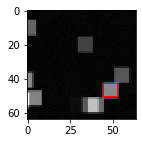

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

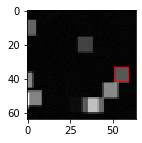

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

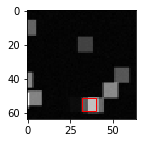

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

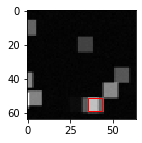

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

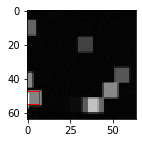

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IndexError: ignored

In [0]:
filter_img_param_ = get_bbox(obj_param_[0],obj_logit_[0],t=0.5)

grid = widgets.Grid(2, 3)
k = 0
for i in range(2):
  for j in range(3):
    with grid.output_to(i, j):
      x,y = param_to_px(filter_img_param_[k])

      plt.figure(figsize=(2, 2))
      plt.imshow(imgs[0].view(img_size,img_size).detach().numpy(),cmap='gray')
      currentAxis=plt.gca()
      rect=patches.Rectangle((x-5, y-5),obj_size,obj_size,linewidth=1,edgecolor='r',facecolor='none')
      currentAxis.add_patch(rect)
      k = k+1

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

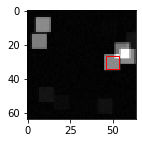

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

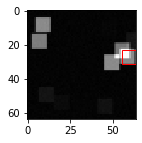

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

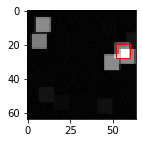

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

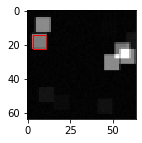

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

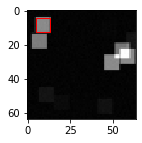

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IndexError: ignored

In [0]:
filter_img_param_ = get_bbox(obj_param_[1],obj_logit_[1],t=0.5)

grid = widgets.Grid(2, 3)
k = 0
for i in range(2):
  for j in range(3):
    with grid.output_to(i, j):
      x,y = param_to_px(filter_img_param_[k])

      plt.figure(figsize=(2, 2))
      plt.imshow(imgs[1].view(img_size,img_size).detach().numpy(),cmap='gray')
      currentAxis=plt.gca()
      rect=patches.Rectangle((x-4, y-4),obj_size,obj_size,linewidth=1,edgecolor='r',facecolor='none')
      currentAxis.add_patch(rect)
      k = k+1